In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv


# Importing Libraries & Environment Setup

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Loading All Datasets & Initial Shape Summary

In [3]:
# Load all datasets
book_visits = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv', parse_dates=['show_date'])
book_theaters = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv')
relation = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv')
book_booking = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv')
date_info = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv')
sample_sub = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv')

print(f"Training rows: {len(book_visits)}, Test predictions: {len(sample_sub)}")


Training rows: 214046, Test predictions: 38062


# Basic EDA & Initial Data Exploration (Date Conversion, Distribution, Trends)

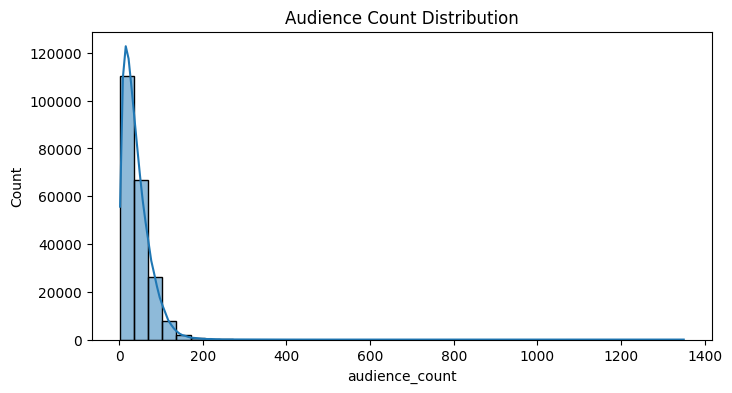

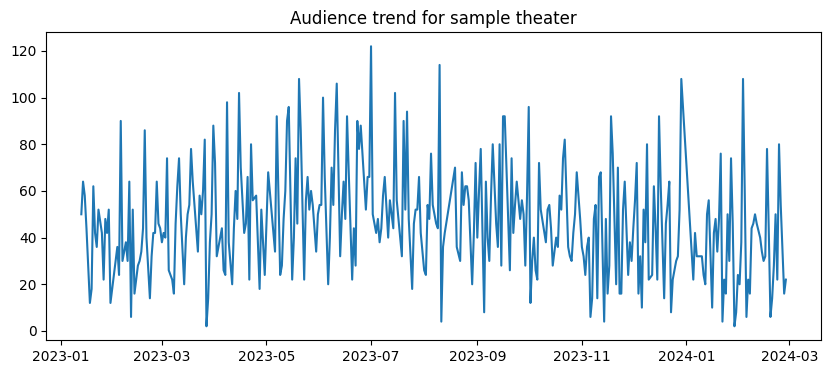

In [4]:
# Convert dates
book_visits['show_date'] = pd.to_datetime(book_visits['show_date'])
date_info['show_date'] = pd.to_datetime(date_info['show_date'])

# Simple EDA
plt.figure(figsize=(8,4))
sns.histplot(book_visits['audience_count'], bins=40, kde=True)
plt.title("Audience Count Distribution")
plt.show()

sample_th = book_visits['book_theater_id'].iloc[0]
temp = book_visits[book_visits['book_theater_id'] == sample_th]

plt.figure(figsize=(10,4))
plt.plot(temp['show_date'], temp['audience_count'])
plt.title("Audience trend for sample theater")
plt.show()

# Data Cleaning, Merging & Ticket Feature Engineering

In [5]:
# Merge theater info and date info
df = book_visits.merge(book_theaters, on='book_theater_id', how='left')
df = df.merge(date_info, on='show_date', how='left')

# Fill missing values
df['theater_type'] = df['theater_type'].fillna('UNKNOWN')
df['theater_area'] = df['theater_area'].fillna('UNKNOWN')
df['latitude'] = df['latitude'].fillna(df['latitude'].mean())
df['longitude'] = df['longitude'].fillna(df['longitude'].mean())

# BookNow booking 
book_booking['show_date'] = pd.to_datetime(book_booking['show_datetime']).dt.normalize()
book_summary = book_booking.groupby(['book_theater_id','show_date'])['tickets_booked'].sum().reset_index()
book_summary.columns = ['book_theater_id','show_date','booknow_daily_tickets']
df = df.merge(book_summary, on=['book_theater_id','show_date'], how='left')
df['booknow_daily_tickets'] = df['booknow_daily_tickets'].fillna(0)

# CinePOS booking
cine_booking = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv')
cine_booking['show_date'] = pd.to_datetime(cine_booking['show_datetime']).dt.normalize()

cp = cine_booking.groupby(['cine_theater_id','show_date'])['tickets_sold'].sum().reset_index()
cp.columns = ['cine_theater_id','show_date','cp_daily_tickets']
cp = cp.merge(relation, on='cine_theater_id', how='left')
cp = cp.groupby(['book_theater_id','show_date'])['cp_daily_tickets'].sum().reset_index()

df = df.merge(cp, on=['book_theater_id','show_date'], how='left')
df['cp_daily_tickets'] = df['cp_daily_tickets'].fillna(0)

df['total_daily_tickets'] = df['booknow_daily_tickets'] + df['cp_daily_tickets']

print("Booking features added", df.shape)

Booking features added (214046, 11)


# Time-Series Feature Engineering (Lag, Rolling & Date Features)

In [6]:
df = df.sort_values(['book_theater_id','show_date']).reset_index(drop=True)

df['weekday'] = df['show_date'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)
df['month'] = df['show_date'].dt.month
df['day'] = df['show_date'].dt.day
df['dayofyear'] = df['show_date'].dt.dayofyear
df['is_month_start'] = df['show_date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['show_date'].dt.is_month_end.astype(int)

def add_lags(g):
    g = g.sort_values('show_date')
    g['aud_lag1'] = g['audience_count'].shift(1).fillna(0)
    g['aud_7_mean'] = g['audience_count'].shift(1).rolling(7,min_periods=1).mean().fillna(0)
    g['aud_14_mean'] = g['audience_count'].shift(1).rolling(14,min_periods=1).mean().fillna(0)
    g['aud_28_mean'] = g['audience_count'].shift(1).rolling(28,min_periods=1).mean().fillna(0)
    g['booknow_lag7'] = g['booknow_daily_tickets'].shift(1).rolling(7,min_periods=1).sum().fillna(0)
    g['cp_lag7'] = g['cp_daily_tickets'].shift(1).rolling(7,min_periods=1).sum().fillna(0)
    g['total_lag7'] = g['total_daily_tickets'].shift(1).rolling(7,min_periods=1).sum().fillna(0)
    return g

df = df.groupby('book_theater_id', group_keys=False).apply(add_lags).reset_index(drop=True)

print("Feature engineering complete", df.shape)

Feature engineering complete (214046, 25)


# Extended EDA (Audience Patterns, Theater Distribution & Correlations)

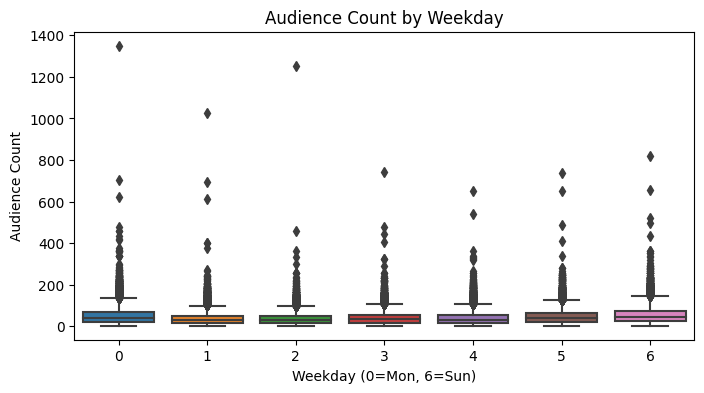

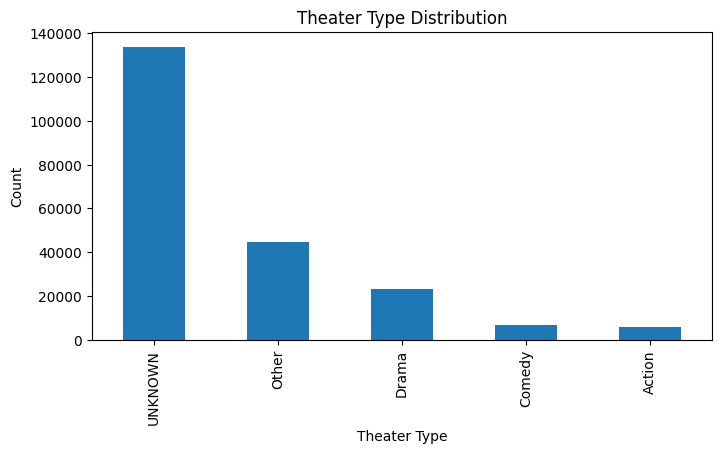

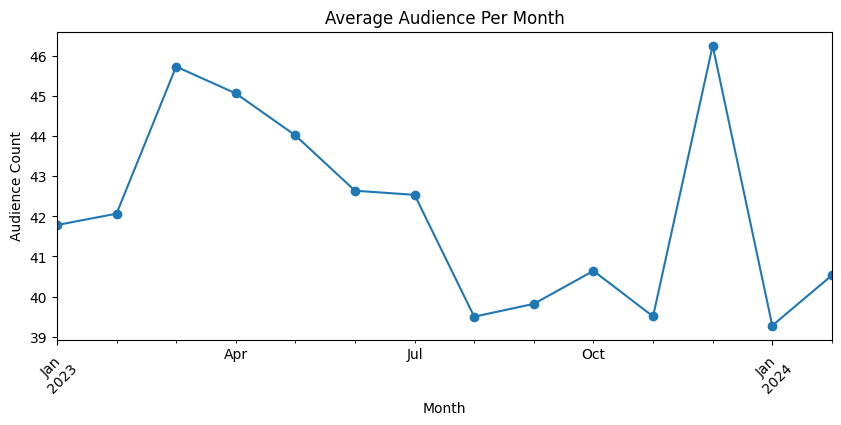

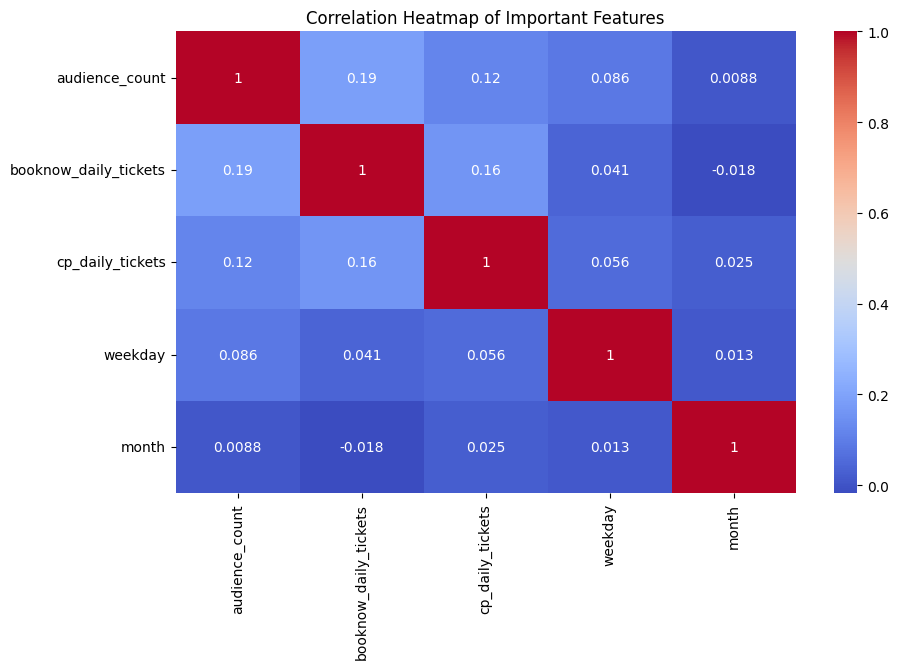

In [7]:
# EXTRA EDA VISUALS 
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Audience Count vs Weekday
plt.figure(figsize=(8,4))
sns.boxplot(x=df['show_date'].dt.weekday, y=df['audience_count'])
plt.title("Audience Count by Weekday")
plt.xlabel("Weekday (0=Mon, 6=Sun)")
plt.ylabel("Audience Count")
plt.show()

# 2. Theater Type Distribution
plt.figure(figsize=(8,4))
df['theater_type'].value_counts().plot(kind='bar')
plt.title("Theater Type Distribution")
plt.xlabel("Theater Type")
plt.ylabel("Count")
plt.show()

# 3. Monthly Audience Trend
monthly_trend = df.groupby(df['show_date'].dt.to_period('M'))['audience_count'].mean()
plt.figure(figsize=(10,4))
monthly_trend.plot(marker='o')
plt.title("Average Audience Per Month")
plt.ylabel("Audience Count")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.show()

# 4. Correlation Heatmap of Key Features
plt.figure(figsize=(10,6))
sns.heatmap(
    df[['audience_count','booknow_daily_tickets','cp_daily_tickets','weekday','month']]
    .corr(),
    annot=True, cmap='coolwarm'
)
plt.title("Correlation Heatmap of Important Features")
plt.show()

# Encoding Categorical Features & Preparing Final Feature Matrix

In [8]:
for c in ['day_of_week', 'theater_type', 'theater_area']:
    if c in df.columns:
        df[c] = pd.factorize(df[c].astype(str))[0]

features = [
    'weekday','is_weekend','month','day','dayofyear','is_month_start','is_month_end',
    'aud_lag1','aud_7_mean','aud_14_mean','aud_28_mean',
    'booknow_lag7','cp_lag7','total_lag7','latitude','longitude',
    'day_of_week','theater_type','theater_area'
]

features = [f for f in features if f in df.columns]

df['y'] = np.log1p(df['audience_count'])

print("Features ready:", len(features))

Features ready: 19


# Model Comparison (LightGBM vs RandomForest vs XGBoost)

In [9]:
print("MODEL COMPARISON (LGBM / RF / XGB)")

# Time-based split
last_date = df['show_date'].max()
val_from = last_date - pd.Timedelta(days=13)

train = df[df['show_date'] < val_from].reset_index(drop=True)
val = df[df['show_date'] >= val_from].reset_index(drop=True)

Xtr = train[features]
ytr = train['y']
Xv = val[features]
yv = val['y']

results = {}

# 1) LightGBM
lgb_tmp = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    num_leaves=64,
    random_state=42
)
lgb_tmp.fit(Xtr, ytr)
pred = lgb_tmp.predict(Xv)
results['LightGBM'] = mean_squared_error(np.expm1(yv), np.expm1(pred), squared=False)

# 2) Random Forest
rf = RandomForestRegressor(
    n_estimators=150,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)
rf.fit(Xtr, ytr)
pred = rf.predict(Xv)
results['RandomForest'] = mean_squared_error(np.expm1(yv), np.expm1(pred), squared=False)

# 3) XGBoost
xgb = XGBRegressor(
    objective="reg:squarederror",
    learning_rate=0.05,
    max_depth=6,
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
xgb.fit(Xtr, ytr)
pred = xgb.predict(Xv)
results['XGBoost'] = mean_squared_error(np.expm1(yv), np.expm1(pred), squared=False)

print("\n Model Comparison:")
for m,v in results.items():
    print(f"{m:12s} → RMSE: {v:.4f}")

MODEL COMPARISON (LGBM / RF / XGB)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2101
[LightGBM] [Info] Number of data points in the train set: 204074, number of used features: 19
[LightGBM] [Info] Start training from score 3.444882

 Model Comparison:
LightGBM     → RMSE: 22.5616
RandomForest → RMSE: 22.5410
XGBoost      → RMSE: 22.1910


# Final LightGBM Training with Early Stopping (Best Model Selection)

In [10]:
# Time split again 
train = df[df['show_date'] < val_from].reset_index(drop=True)
val = df[df['show_date'] >= val_from].reset_index(drop=True)

lgb_train = lgb.Dataset(train[features], label=train['y'])
lgb_val = lgb.Dataset(val[features], label=val['y'], reference=lgb_train)

params = {
    'objective':'regression',
    'metric':'rmse',
    'learning_rate':0.05,
    'num_leaves':64,
    'seed':42,
    'verbosity':-1
}

bst = lgb.train(
    params, lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[lgb.early_stopping(stopping_rounds=50),
               lgb.log_evaluation(period=100)]
)

val_pred = bst.predict(val[features], num_iteration=bst.best_iteration)
val_rmse = mean_squared_error(np.expm1(val['y']), np.expm1(val_pred), squared=False)

print("\n Validation RMSE:", val_rmse)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.596046	valid_1's rmse: 0.579957
Early stopping, best iteration is:
[86]	training's rmse: 0.598256	valid_1's rmse: 0.579155

 Validation RMSE: 22.54617347114193


# Correlation Analysis of Important Features

## CELL 6A — Correlation Heatmap

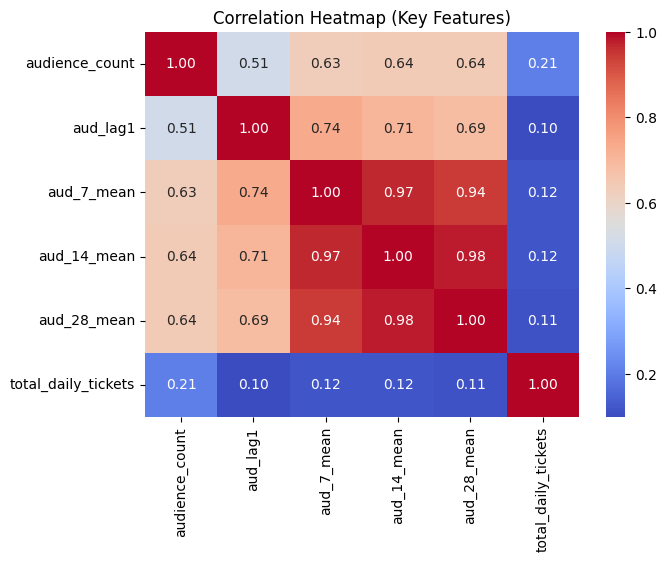

In [11]:
corr = df[['audience_count','aud_lag1','aud_7_mean','aud_14_mean','aud_28_mean','total_daily_tickets']].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Key Features)")
plt.show()

# Recursive Forecasting for Test Set (Final Predictions)

In [12]:
sample = sample_sub.copy()
sample['book_theater_id'] = sample['ID'].str.rsplit(pat="_", n=1).str[0]
sample['show_date'] = pd.to_datetime(sample['ID'].str.rsplit(pat="_", n=1).str[1])

preds = []

for th in sample['book_theater_id'].unique():
    th_rows = sample[sample['book_theater_id']==th].sort_values('show_date')
    hist = df[df['book_theater_id']==th].sort_values('show_date')

    if hist.shape[0]==0:
        fallback=int(df['audience_count'].median())
        for _,r in th_rows.iterrows(): preds.append((r['ID'],fallback))
        continue
    
    state = hist.iloc[-1:].copy().reset_index(drop=True)
    last = state.at[0,'show_date']
    
    for _,row in th_rows.iterrows():
        tgt=row['show_date']
        cur=last
        
        while cur<tgt:
            nxt = cur+pd.Timedelta(days=1)
            feat={
                'weekday':nxt.weekday(),
                'is_weekend':int(nxt.weekday() in [5,6]),
                'month':nxt.month,
                'day':nxt.day,
                'dayofyear':nxt.dayofyear,
                'is_month_start':int(nxt.is_month_start),
                'is_month_end':int(nxt.is_month_end),
            }
            for k in features:
                if k not in feat:
                    feat[k]=float(state[k].iloc[0]) if k in state.columns else 0.0
            
            Xn=pd.DataFrame([feat],columns=features)
            ylog=bst.predict(Xn, num_iteration=bst.best_iteration)[0]
            y=max(0,float(np.expm1(ylog)))
            
            new={'show_date':nxt,'audience_count':y,'y':np.log1p(y),
                 'aud_lag1':float(state.at[0,'audience_count'])}
            
            for fe in ['aud_7_mean','aud_14_mean','aud_28_mean']:
                new[fe]=float(state[fe].iloc[0]) if fe in state.columns else new['aud_lag1']
            
            for fe in ['booknow_lag7','cp_lag7','total_lag7','latitude','longitude']:
                new[fe]=float(state[fe].iloc[0]) if fe in state.columns else 0.0
            
            state=pd.DataFrame([new])
            cur=nxt
            last=nxt
        
        preds.append((row['ID'],int(round(state.at[0,'audience_count']))))
        
print("Generated predictions:",len(preds))

Generated predictions: 38062


# Creating Submission CSV File

In [13]:
submission = pd.DataFrame(preds, columns=['ID','audience_count'])
submission.to_csv("submission.csv", index=False)

print("submission.csv ready")
print(submission.head())

submission.csv ready
                      ID  audience_count
0  book_00001_2024-03-01              27
1  book_00001_2024-03-02              35
2  book_00001_2024-03-03              37
3  book_00001_2024-03-04              34
4  book_00001_2024-03-06              27
